In [2]:
from PIL import Image, ImageFilter, ImageChops
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import itertools

In [3]:
img0 = Image.open('dataset1/0.bmp').convert('L')
img1 = Image.open('dataset1/1.bmp').convert('L')
img2 = Image.open('dataset1/2.bmp').convert('L')
img3 = Image.open('dataset1/3.bmp').convert('L')
images = [img0, img1, img2, img3]

In [4]:
# Send in np array foe each image
def show_images(images):
    plt.figure(figsize=(200,100))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image, cmap=plt.get_cmap('gray'))

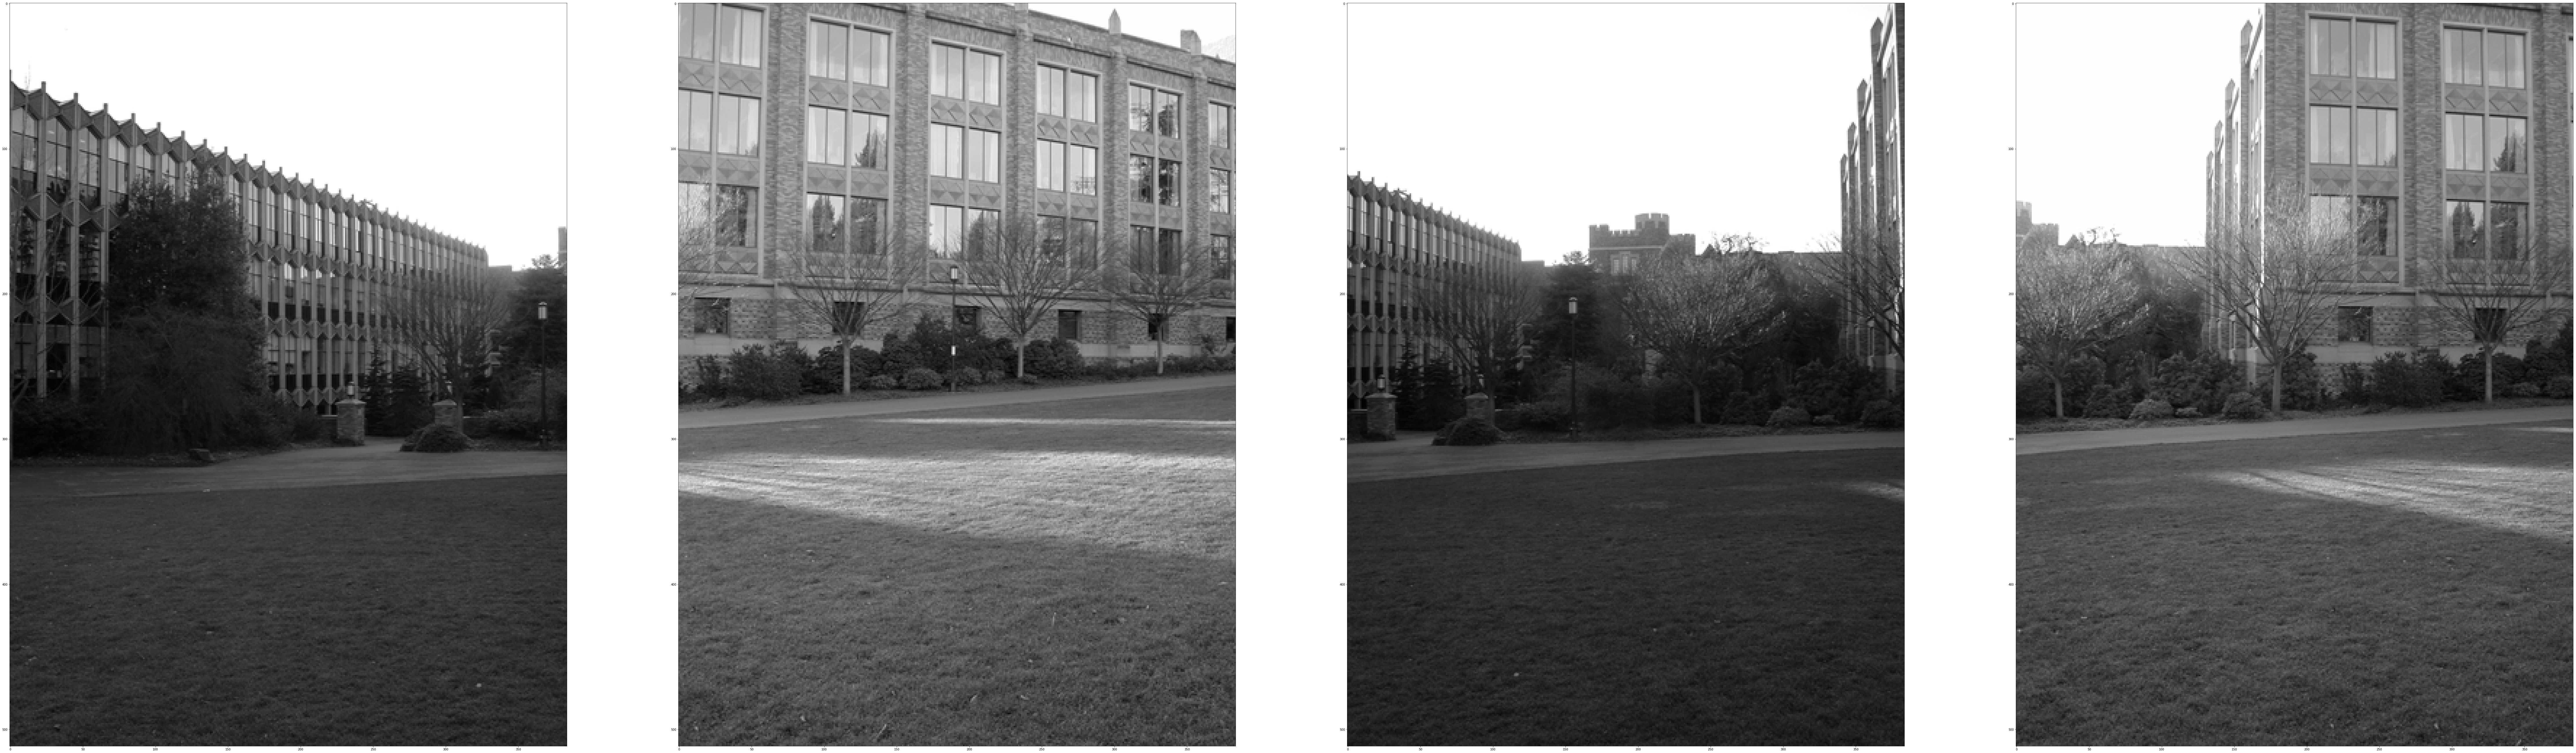

In [5]:
arr = [np.array(i) for i in images]
show_images(arr)

In [6]:
array = [[] for x in range(5)]
# array.append([])
# array[0].append(img0)
array

[[], [], [], [], []]

In [7]:
def scale_space(img, num_octaves, blurs_per_octave, blur_radius=1/math.sqrt(2)):
    img = img.resize((2*img.width, 2*img.height), Image.ANTIALIAS)
    scale_space_images = [[] for x in range(num_octaves)]
    for octave in range(num_octaves):
        if octave:
            img = img.resize((img.width // 2, img.height // 2), Image.ANTIALIAS)
        for blur in range(blurs_per_octave):
            current_blur_radius = blur_radius * 2**(octave) * math.sqrt(2)**blur
            current_image = img.filter(ImageFilter.GaussianBlur(current_blur_radius))
            scale_space_images[octave].append(current_image)
    return scale_space_images

In [8]:
scale_images = scale_space(img0, 4, 5)
# scale_images[0][0]

<class 'list'>


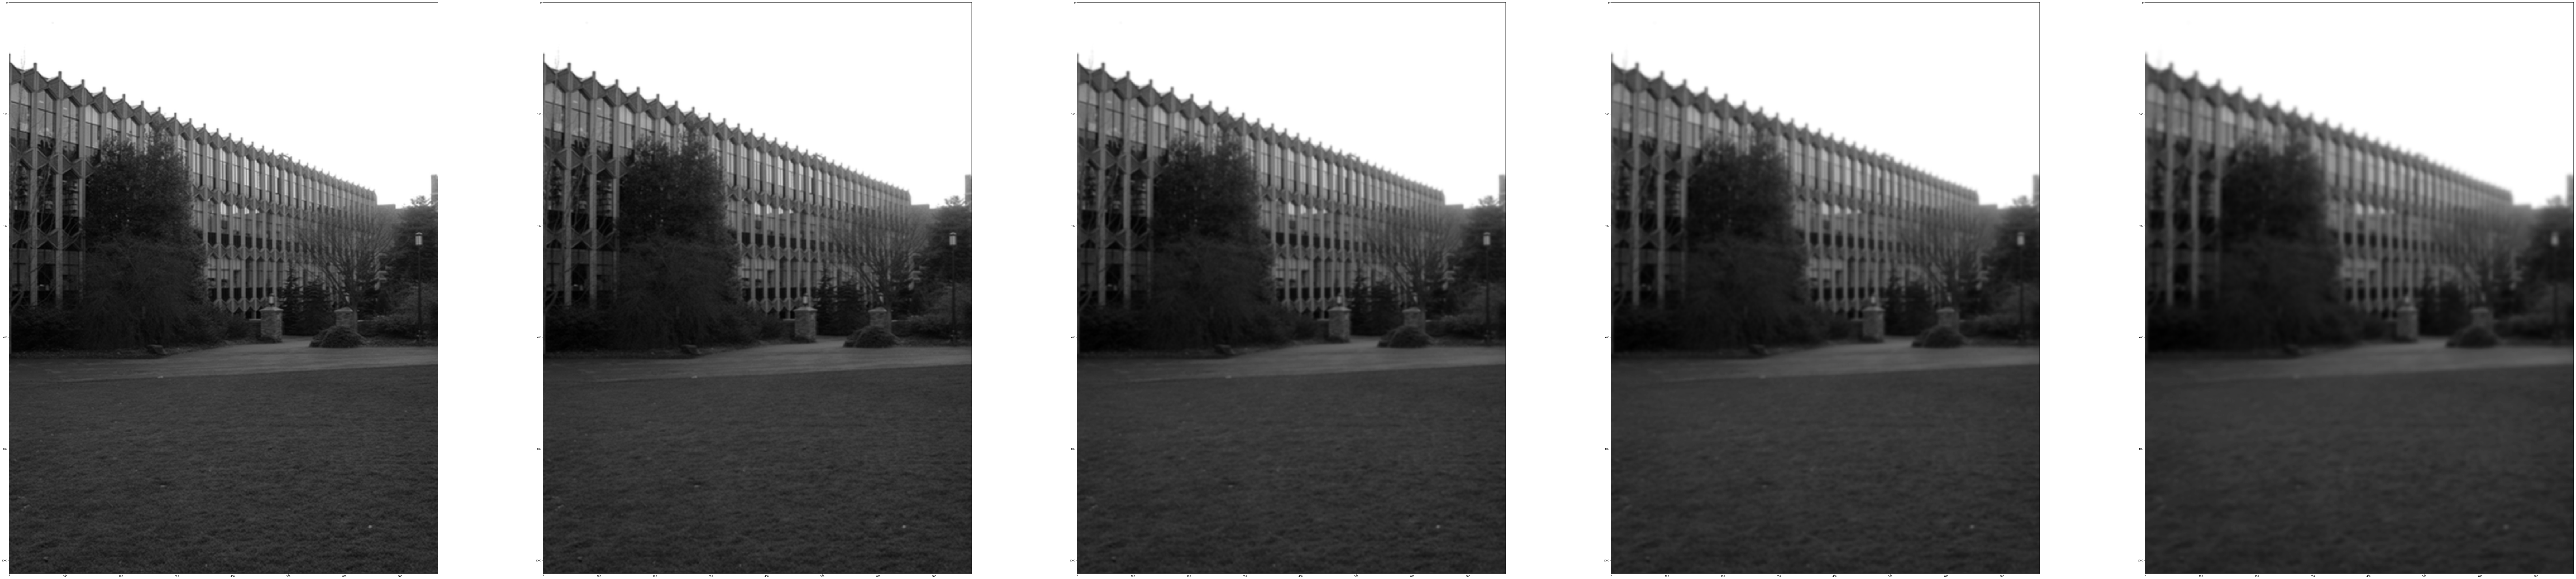

In [9]:
show_images([np.array(x) for x in scale_images[0]])
print(type(scale_images))

In [10]:
# LoG is computationally expensive
# DoG is much faster and can be used as an approximation
def create_DoG(first_image, second_image):
    return ImageChops.difference(first_image, second_image)

def create_scale_images_DoG(scale_images):
    diff_of_gaussians = []
    for octave in scale_images:
        diff_of_gaussians.append([create_DoG(octave[x], octave[x+1]) for x in range(len(octave)-1)])
        
    return diff_of_gaussians


In [11]:
diff_of_gauss = create_scale_images_DoG(scale_images)

In [12]:
def convert_PIL_to_numpy(image):
    return np.array(image)

def convert_images_to_numpy(images):
    np_images = []
    for octave in images:
        np_images.append([convert_PIL_to_numpy(octave[x]) for x in range(len(octave))])
        
    return np_images

In [13]:
diff_of_gauss = convert_images_to_numpy(diff_of_gauss)

In [35]:
def find_keypoints(diff_of_gauss):
    keypoints = []
    directions = list([list(x) for x in itertools.product([-1, 0, 1], repeat=3) if x != (0, 0, 0)])
    for idx, octave in enumerate(diff_of_gauss):
        # Iterate between the sandwiched layers
        for p_curr_layer in range(1, len(octave) - 1):
            layer = octave[p_curr_layer]
            # Assuming that image edges are not valid keypoints (lack of neighbours)
            for p_curr_row in range(1, len(layer)-1):
                for p_curr_col in range(1, len(layer[p_curr_row])-1):
                    # Add a case to skip adding to list if indices are all 0
                    # TODO(sumobot1): Change function to stop after detecting a neighbouring pixel with a higher/lower value
                    adjacent_points = list(map(lambda indices: octave[p_curr_layer+indices[0]][p_curr_row+indices[1]][p_curr_col+indices[2]], directions))
                    if any(point >= layer[p_curr_row][p_curr_col] for point in adjacent_points) and any(point <= layer[p_curr_row][p_curr_col] for point in adjacent_points):
                        continue
                    keypoints.append((idx, p_curr_layer, p_curr_row, p_curr_col))
    return keypoints
                    
#                     for p_neigh_layer in range(p_curr_layer - 1, p_curr_layer + 2):
#                         for p_neigh_row in range(p)
thing = find_keypoints(diff_of_gauss)
            

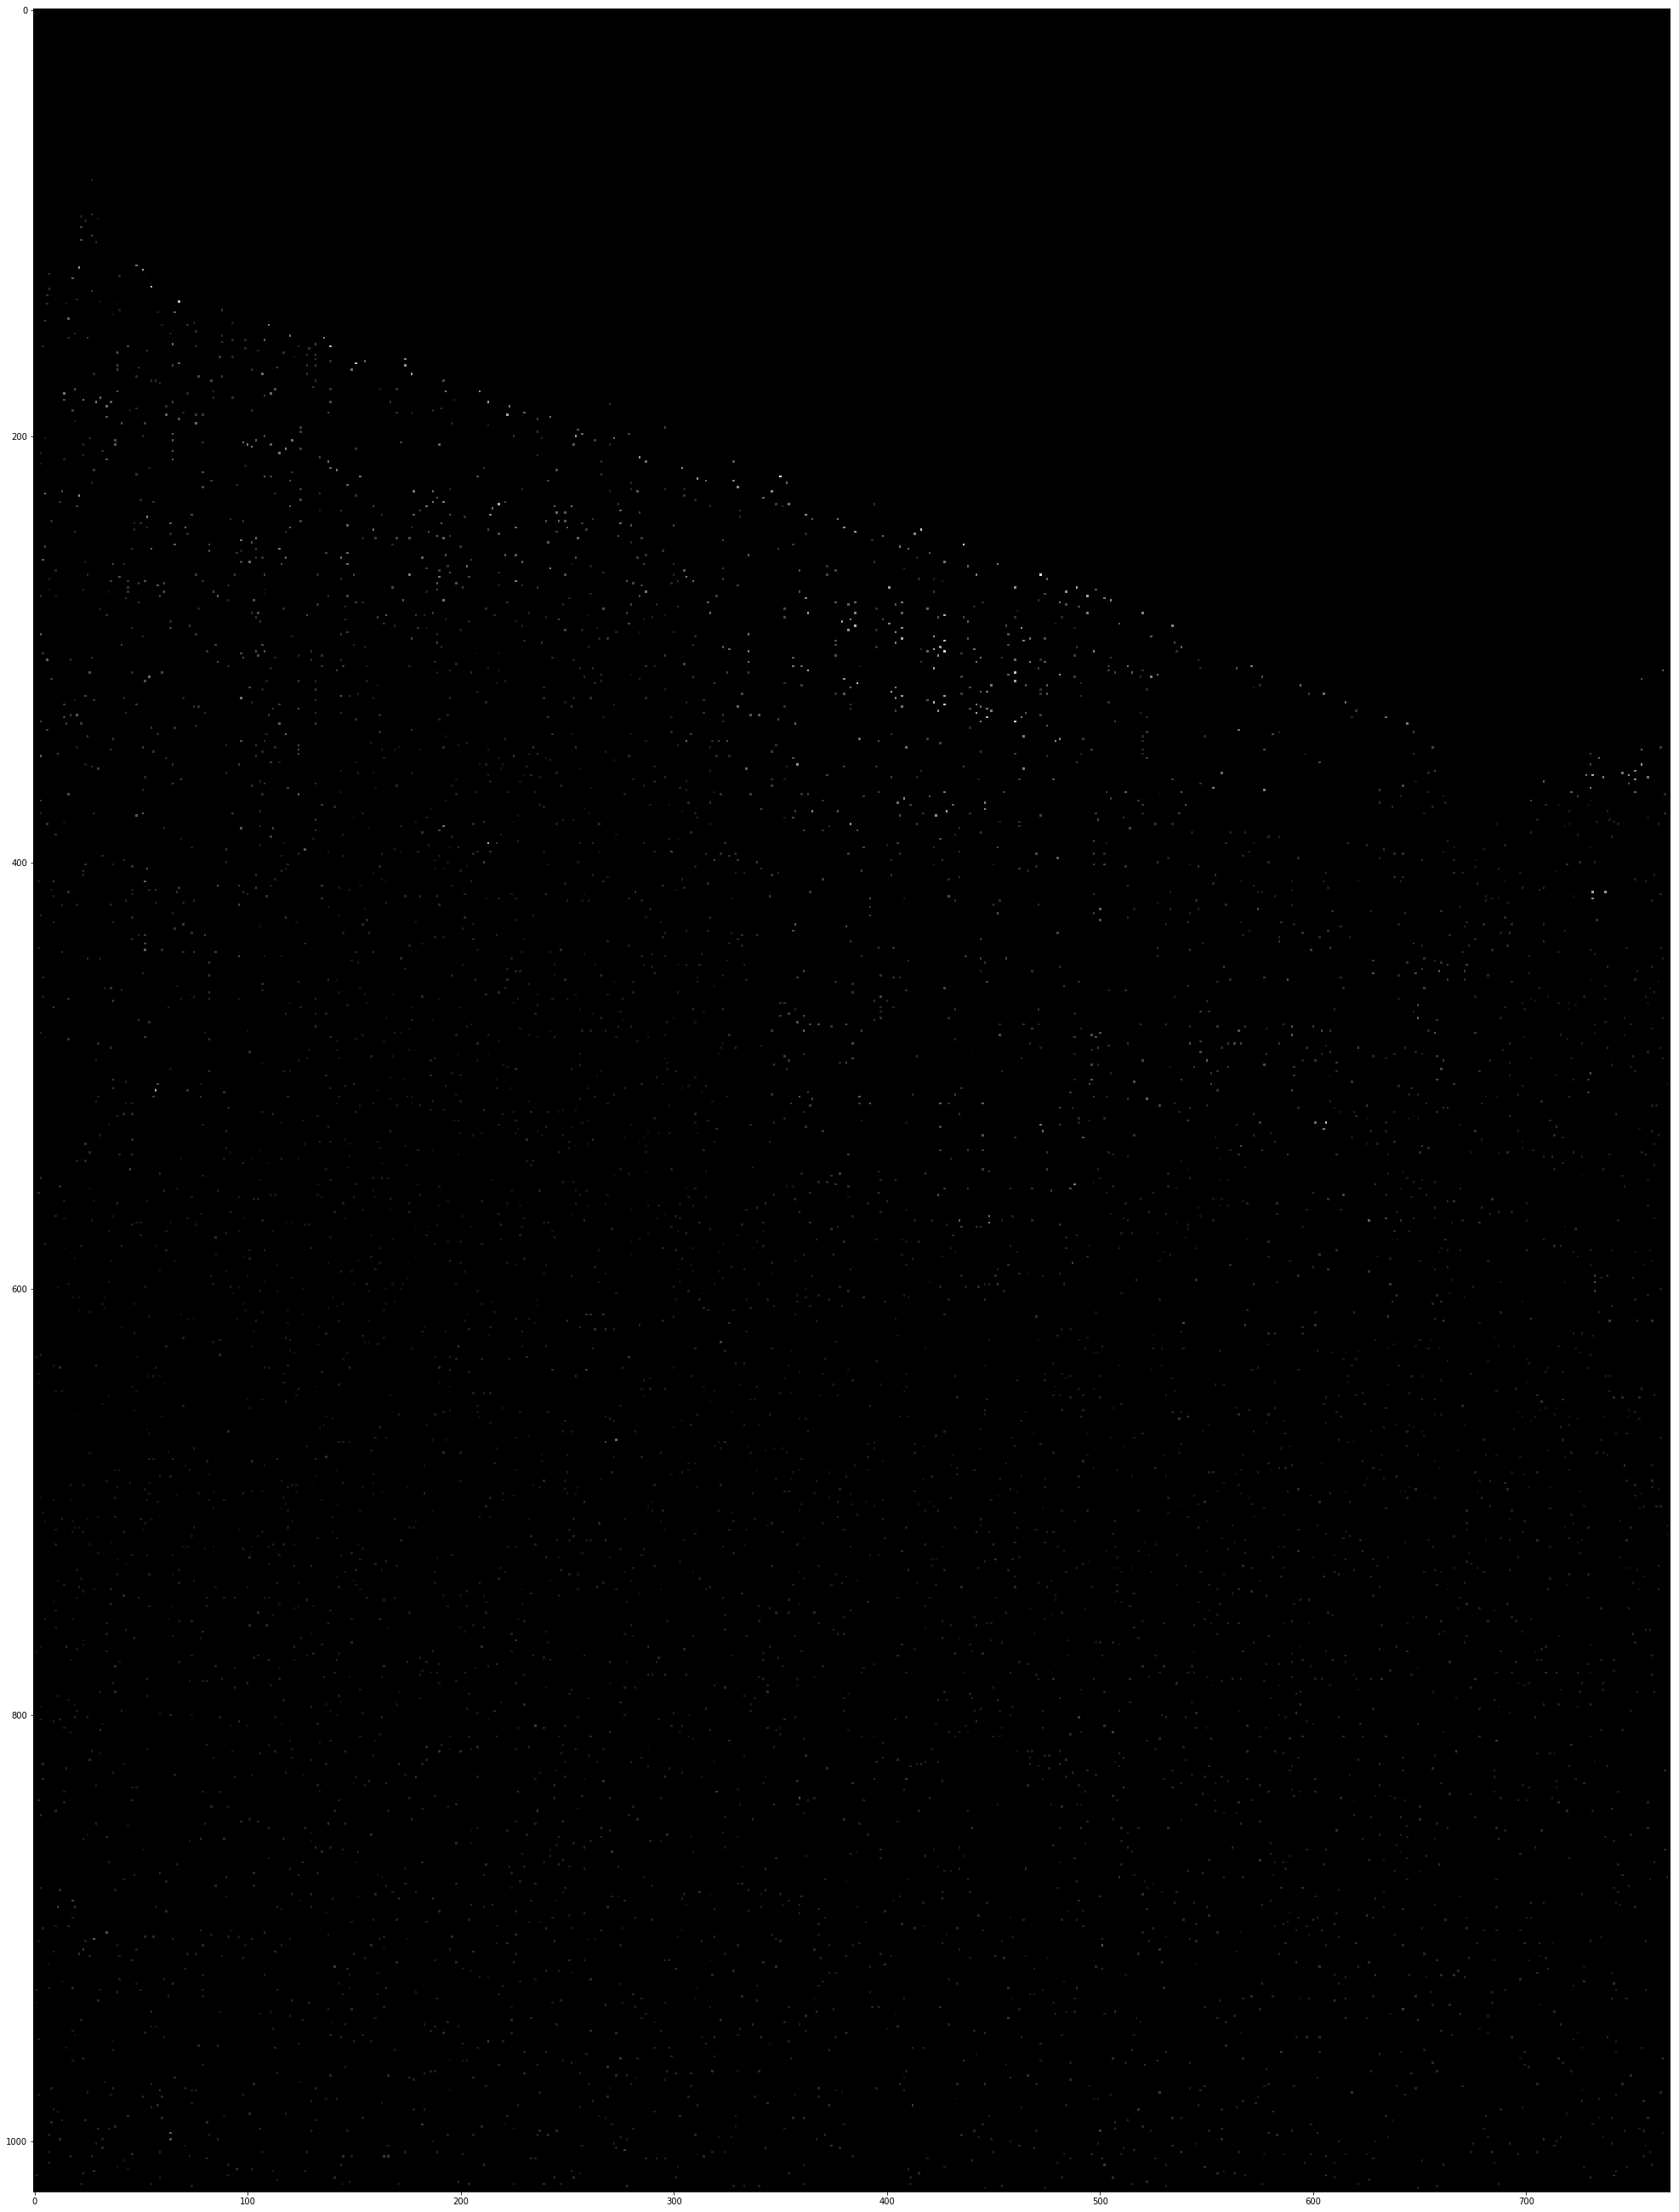

In [40]:
# Used for testing purposes
def display_first_image(diff_of_gauss, thing):
    img =  np.zeros((len(diff_of_gauss[0][0]), len(diff_of_gauss[0][0][0])))
    for octave, layer, row, col in thing:
        if octave == 0 and layer == 1:
            img[row, col] = diff_of_gauss[octave][layer][row][col]
    show_images([img])

display_first_image(diff_of_gauss, thing)

In [39]:
# Find subpixel maxima and minima if the stitching doesn't work (apparently it increases accuracy)

In [41]:
averages = [[np.mean(layer) for layer in octave] for octave in diff_of_gauss]
print(averages)

[[0.8693898518880209, 1.186859130859375, 1.1177584330240886, 1.2352574666341145], [1.2425333658854167, 1.3164164225260417, 1.2726491292317708, 1.3772481282552083], [1.5516357421875, 1.7787272135416667, 2.0435587565104165, 2.4963785807291665], [3.26220703125, 4.580403645833333, 6.386474609375, 8.177164713541666]]


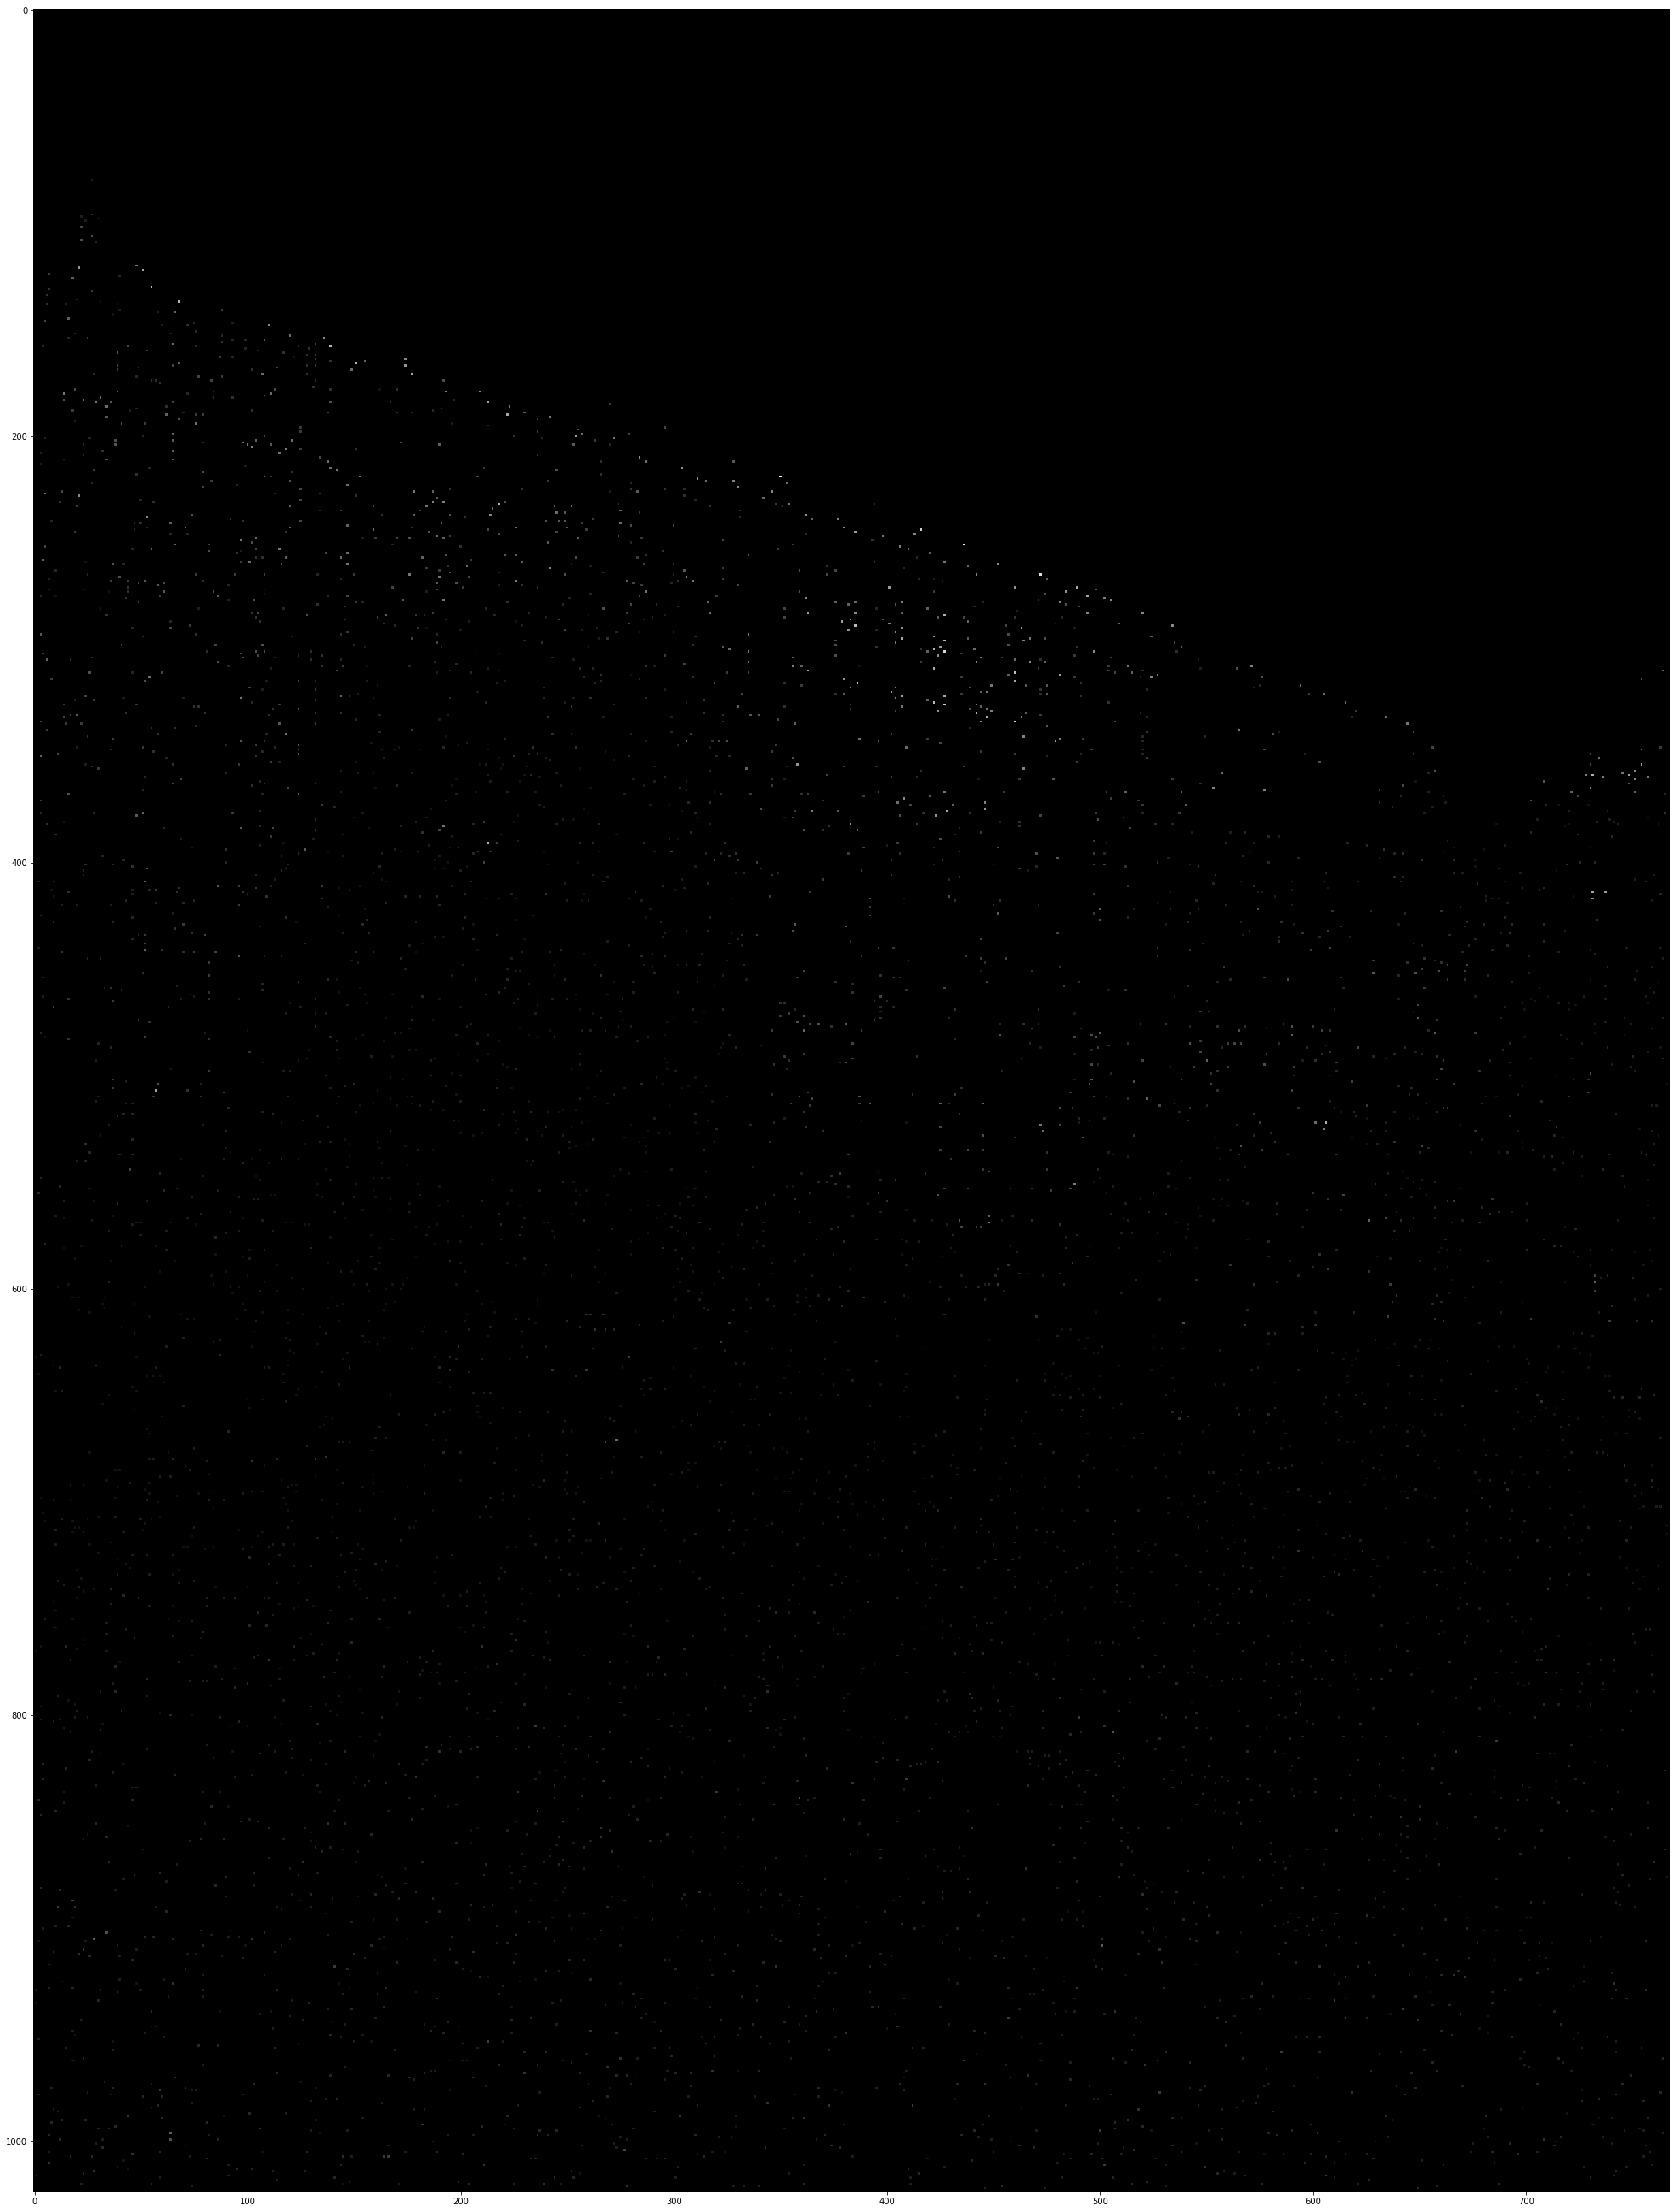

In [46]:
high_contrast_keypoints = [(octave, layer, row, col) for octave, layer, row, col in thing if diff_of_gauss[octave][layer][row][col] < averages[octave][layer] - averages[octave][layer]*0.3 or diff_of_gauss[octave][layer][row][col] > averages[octave][layer] + averages[octave][layer]*0.3]

display_first_image(diff_of_gauss, high_contrast_keypoints)

In [47]:
# Hessian is the double derivative of the DoG
# Hessian is a matrix of the double partial derivatives of the intensities in the x direction and the y direction - this is to show how intensely the images change in each direction
def calculate_hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

# Dimensions: octave, layer, row, col (matches diff_of_gauss)
hessian_diff_of_gauss = [[calculate_hessian(layer) for layer in octave] for octave in diff_of_gauss]

(2, 2, 1024, 768)


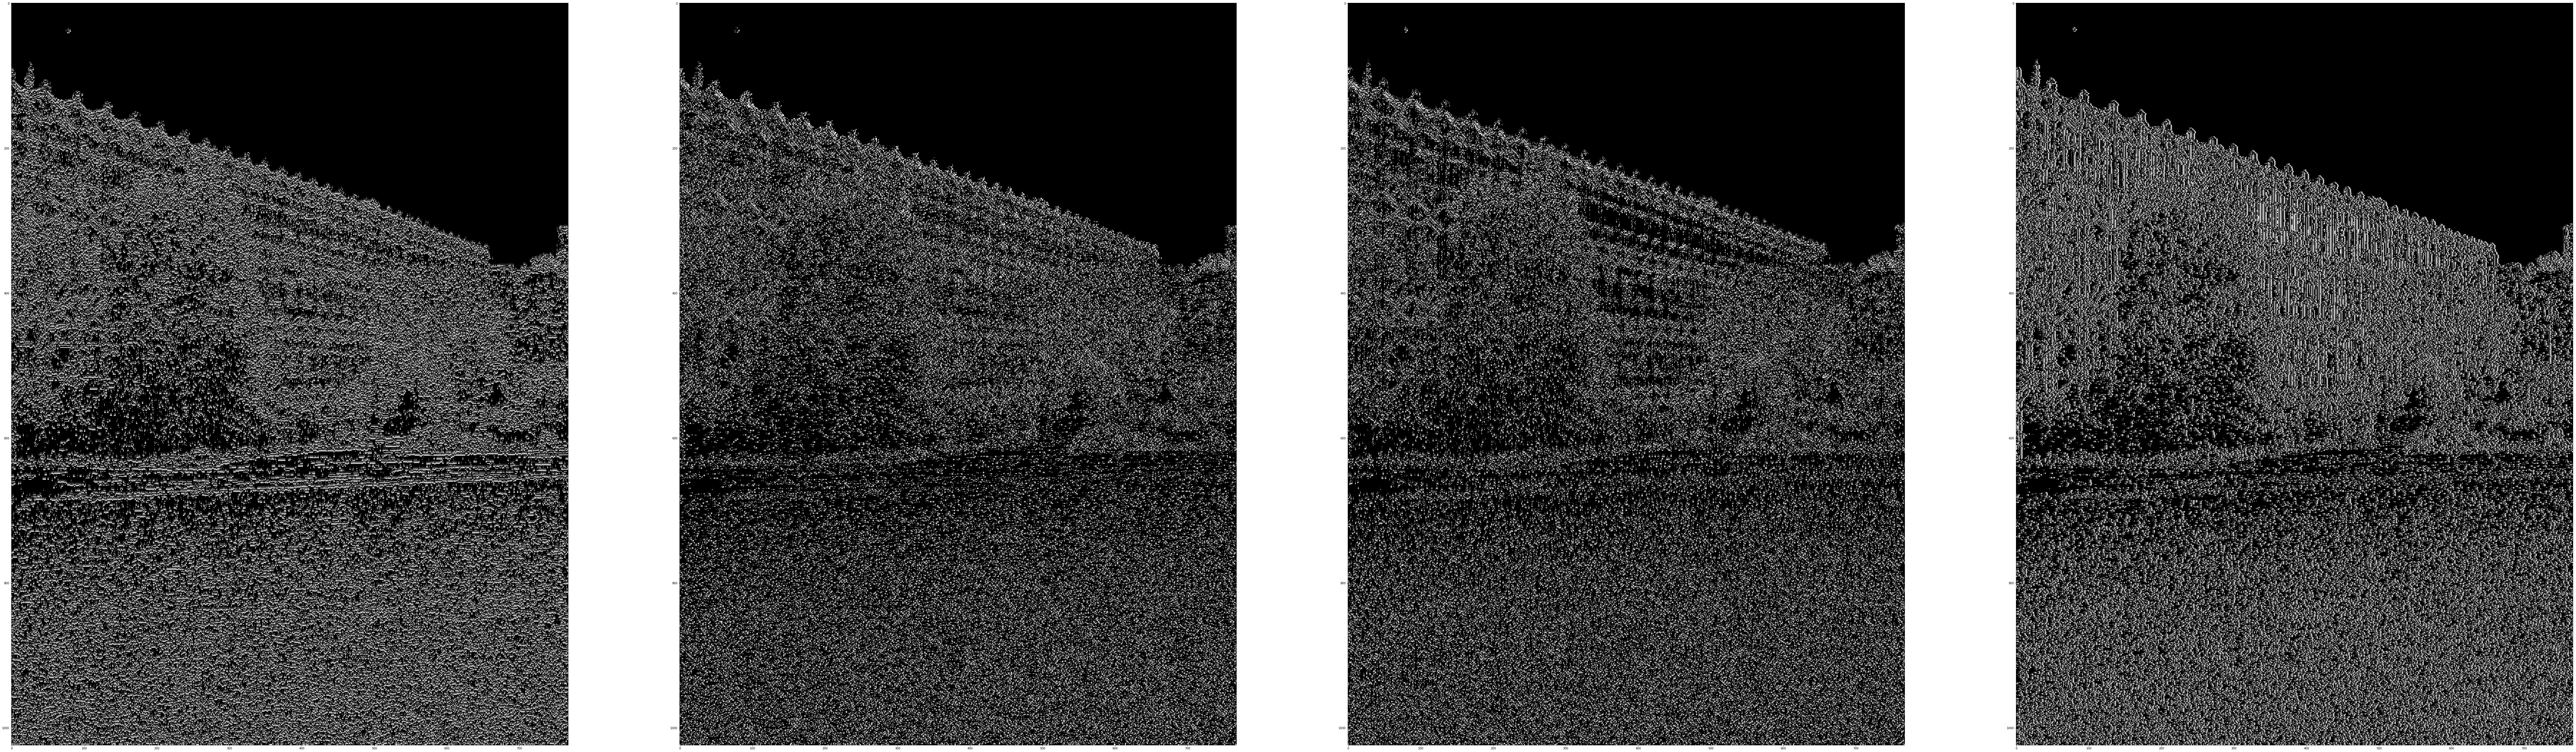

In [62]:
print(hessian_diff_of_gauss[0][0].shape)
show_images([hessian_diff_of_gauss[0][0][0][0], hessian_diff_of_gauss[0][0][0][1], hessian_diff_of_gauss[0][0][1][0], hessian_diff_of_gauss[0][0][1][1]])
# Notice that the second and third images (upper right and lower left) are not the same - we would expect them to be the same (dx/dy and dy/dx), but because the taylor series approximates the derivative, 
# this results in different values when you take the first or second partial derivative

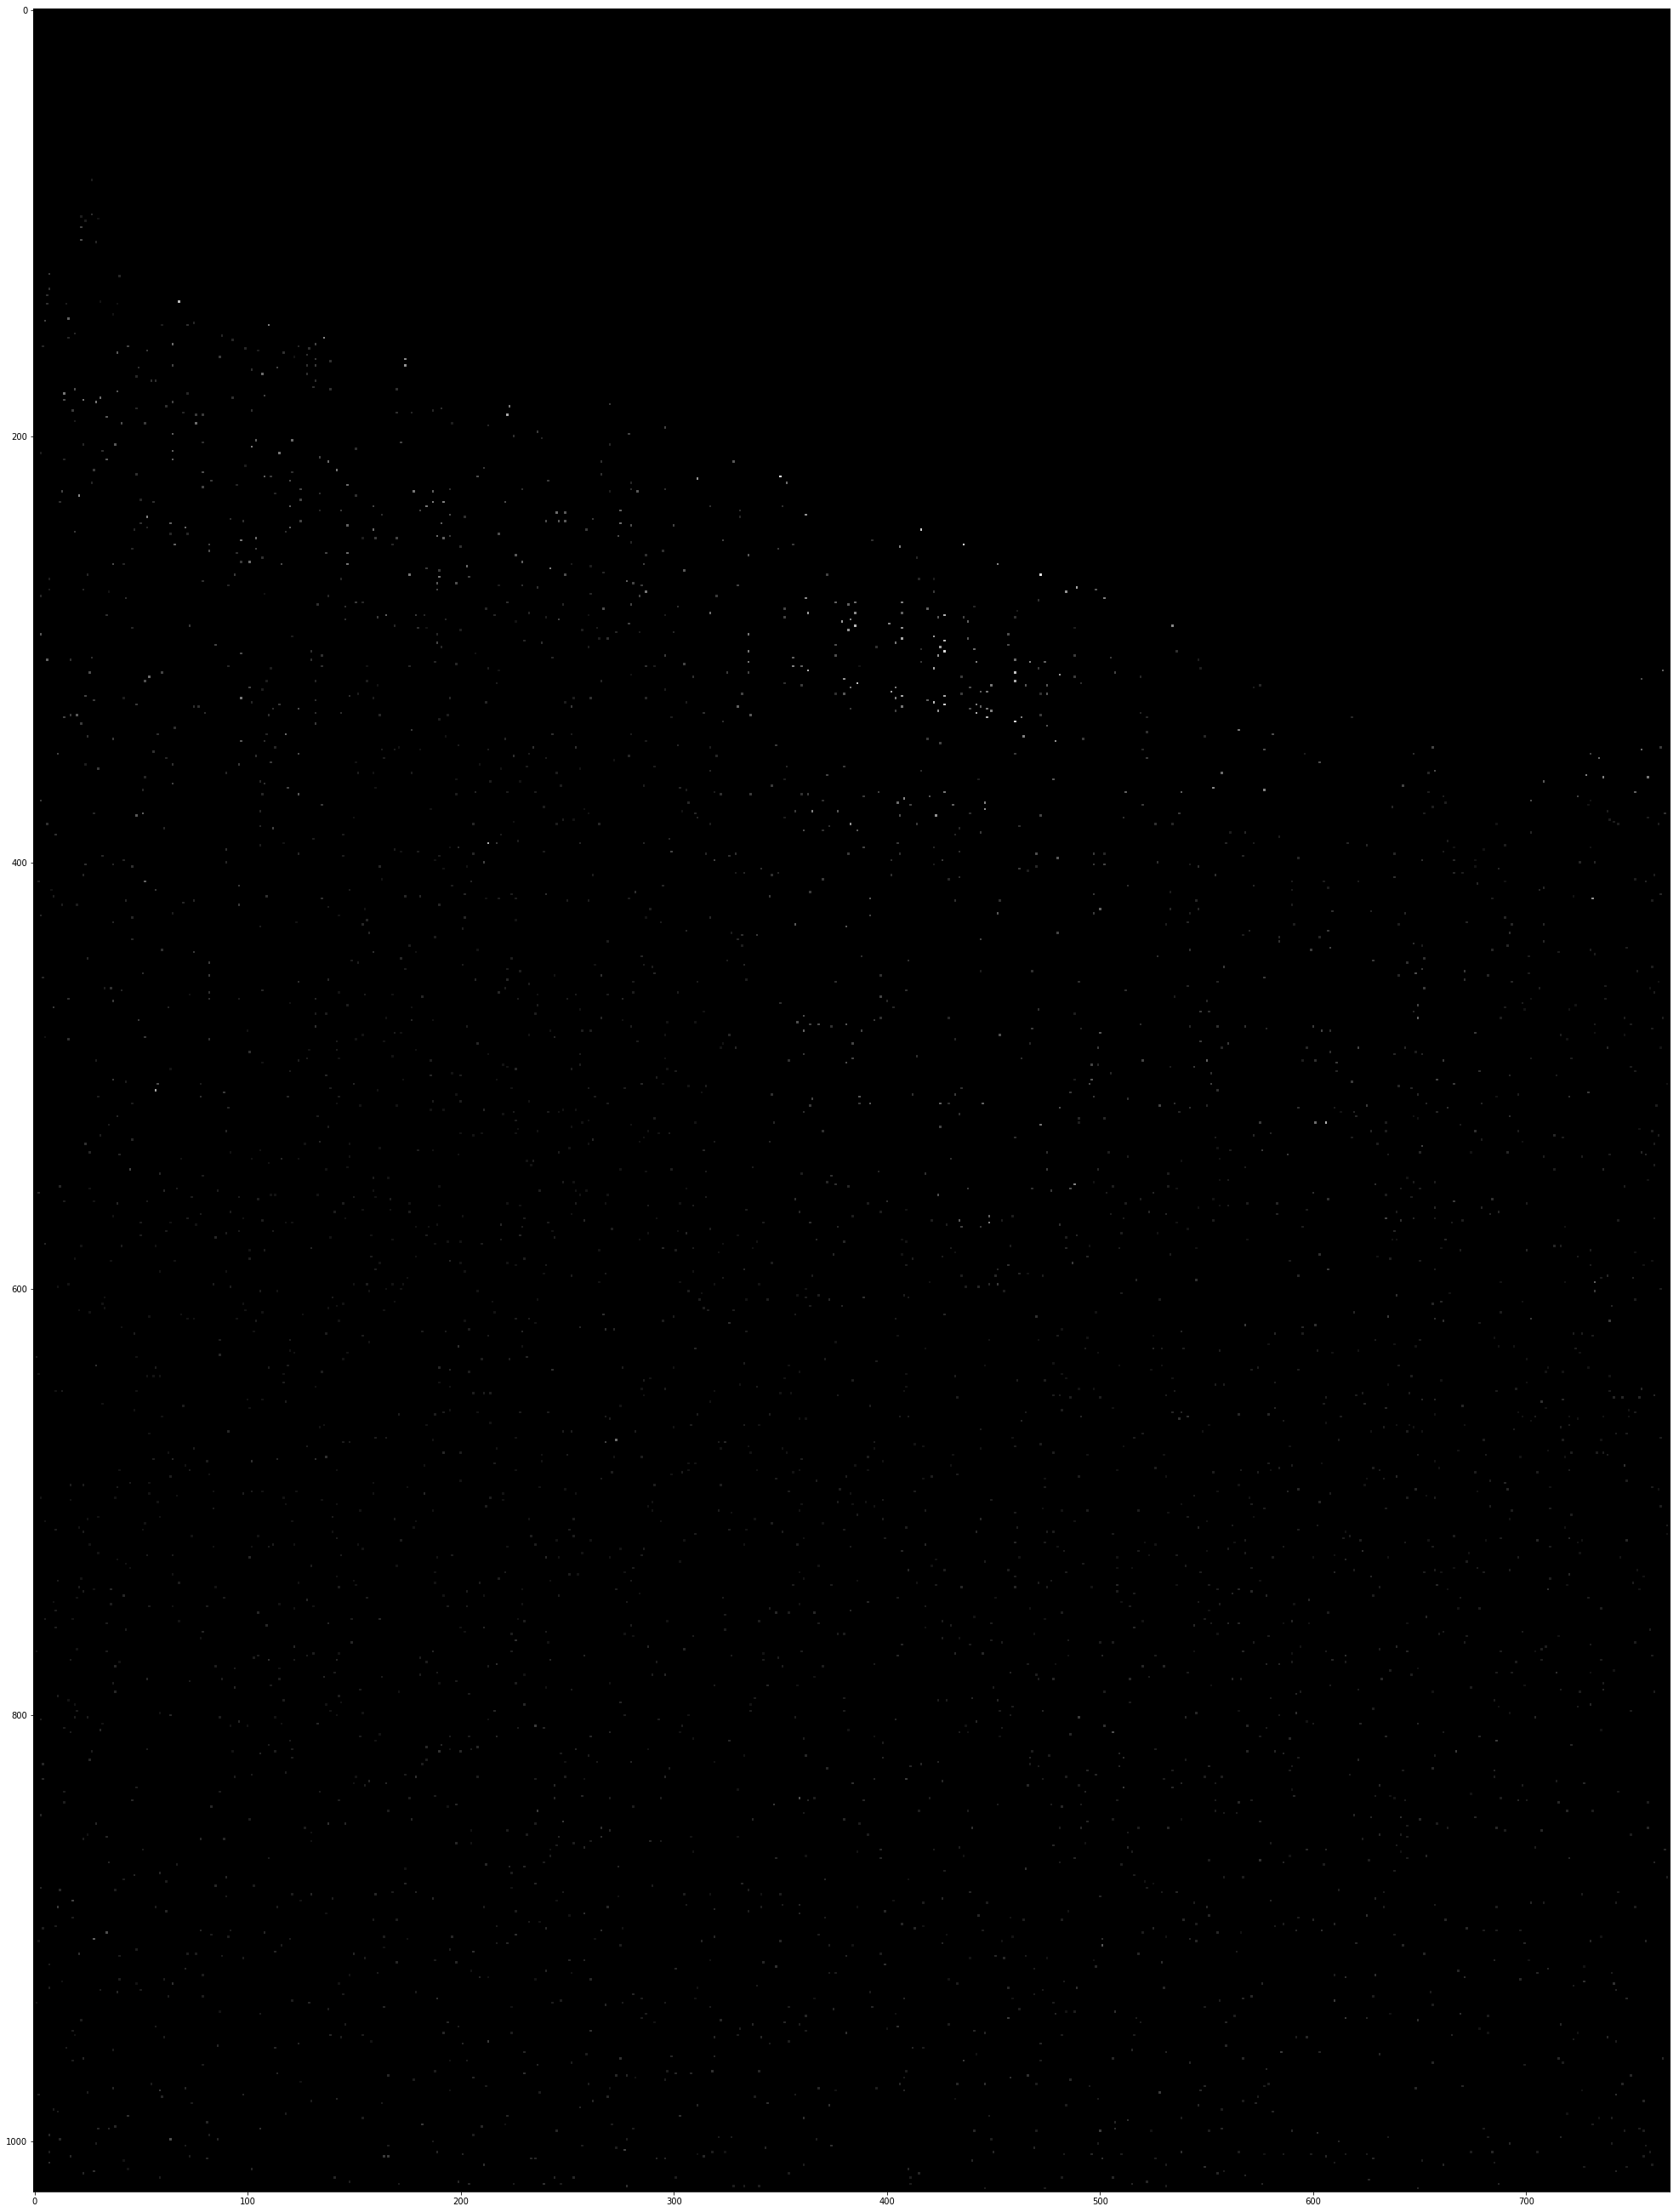

In [67]:
# Trace of a matrix is the sum of the diagonal components in a square matrix
# Formula: https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf
# Tr(H)^2/Det(H) < (r+1)^2/r - Tr = Trace of hessian matrix, H = Hessian Matrix, Det = Determinant, r = 10 (just because)
corner_high_contrast_keypoints = []
for octave, layer, row, col in high_contrast_keypoints:
    hessian = hessian_diff_of_gauss[octave][layer][:,:,row,col]
    if np.trace(hessian)**2 / max(np.linalg.det(hessian), 0.0000000000000000000000000000000000000001) < (10 + 1)**2 / 10:
        corner_high_contrast_keypoints.append((octave, layer, row, col))

display_first_image(diff_of_gauss, corner_high_contrast_keypoints)